## Alpha Factor Evaluation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_market_calendars as mcal
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

In [3]:
hdf_path = Path('..', '00_data', 'assets.h5')
TRADING_DAYS = 21
holding_periods = [m * TRADING_DAYS for m in [3, 6, 9, 12]]

### Get Quandl Wiki Prices

Follow [instructions](https://www.quandl.com/databases/WIKIP/usage/export) to download quandl wiki prices, unzip and rename to `wiki_prices.csv`.

In [8]:
hdf_store = Path('..', '00_data', 'assets.h5')
df = pd.read_hdf(hdf_store, 'quandl/wiki/prices')
df = df.adj_close.unstack()

start, end = df.index[0], df.index[-1]

nyse = mcal.get_calendar('NYSE')
early = nyse.schedule(start_date=start, end_date=end)
trading_dates = mcal.date_range(early, frequency='1D').date
df = df.loc[trading_dates].dropna(how='all')
df.index = pd.to_datetime(df.index)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14155 entries, 1962-01-02 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 345.6 MB


### Relative Momentum

In [10]:
def relative_momentum(asset_prices: pd.DataFrame,
                      lookback: int = 12,
                      shift: int = 0) -> pd.DataFrame:
    """Compute rolling period returns.

    :param asset_prices: DataFrame with prices in columns and DateTimeIndex
    :param lookback: # of months in period (default 12)
    :param shift: # of months to shift period returns
    :param quantiles: # quantiles for period return signal
    :return: pd.DataFrame
    """
    T = TRADING_DAYS * lookback
    S = TRADING_DAYS * shift
    momentum = asset_prices.pct_change(T, limit=int(T / 2))
    momentum = momentum.shift(S)
    return momentum.dropna(how='all', axis=1).dropna(how='all')

In [ ]:
def get_spear(x):
    a = x['factor'].dropna(how='all', axis=1)
    b = x['126D'].dropna(how='all', axis=1)
    print(x.shape, a.shape, b.shape)
    c, std = spearmanr(a=a, b=b, nan_policy='omit')
    return c

In [11]:
def get_candidates():
    with pd.HDFStore('momentum_factor.h5') as store:
        df = store.get(f'relative_momentum/factor_data/18').loc[:, ['126D', 'factor']]

    df = df.unstack().loc['2013': '2015'].dropna(how='all', axis=1)
    df = df.fillna(df.median())
    factor = df.loc[:, 'factor']

    fw = df.loc[:, '126D']
    print(fw.shape, factor.shape)
    stocks = factor.columns.tolist()

    corr, pval = spearmanr(a=factor, b=fw, axis=0)
    result = pd.DataFrame({'corr'   : np.diagonal(corr, offset=len(stocks)),
                           'p-value': np.diagonal(pval, offset=len(stocks))}, index=stocks)

    # corr = df.groupby(pd.Grouper(level='date', freq='A')).apply(get_spear)
    print(corr.nlargest(columns=['corr'], n=200))
    with pd.HDFStore('momentum_factor.h5') as store:
        store.put('relative_momentum/corr/18', result)

### Tune Parameters

In [ ]:
for month in [12, 18, 24, 36]:
    factor = relative_momentum(prices, lookback=month-1, shift=1)

    factor_data = get_clean_factor_and_forward_returns(factor=factor.stack(),
                                                       prices=prices,
                                                       periods=holding_periods,
                                                       quantiles=5)

    print(factor_data.groupby(pd.Grouper(level='date', freq='A')).apply(get_returns))
    ic = factor_information_coefficient(factor_data)
    print(ic.resample('A').mean())
    with pd.HDFStore('momentum_factor.h5') as store:
        store.put(f'relative_momentum_monthly/ic/{month}/all', ic)
        store.put(f'relative_momentum_monthly/factor_data/{month}/all', factor_data)
        store.put(f'relative_momentum_monthly/factor/{month}/all', factor)

In [ ]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(factor_data_sample, by_date=True)

In [ ]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['252D'], period='252D');

In [ ]:
mean_return_by_q, std_err = mean_return_by_quantile(factor_data_sample)

In [ ]:
plot_quantile_returns_bar(mean_return_by_q);

### Good Momentum

In [25]:
month = 18
with pd.HDFStore('momentum_factor.h5') as store:
    factor_data = store.get(f'relative_momentum/factor_data/{month}/best')
    factor = store.get(f'relative_momentum/factor/{month}/best')

In [26]:
factor_data.head()

63D      126D      189D      252D    factor  \
date       asset                                                     
2013-01-02 LORL   0.091089  0.088933  0.219547  0.428854  0.488246   
           STX    0.137402  0.424901  0.465401  0.783241  1.134375   
           BRS    0.167879  0.216566  0.383889  0.384643  0.093157   
           ESV   -0.056593 -0.065506 -0.086338 -0.048493  0.208535   
           OII    0.126653  0.351560  0.481233  0.381915  0.408149   

                  factor_quantile  
date       asset                   
2013-01-02 LORL                 4  
           STX                  5  
           BRS                  2  
           ESV                  2  
           OII                  4

### Relative & Absolute Momentum

In [24]:
lookback = 18
which = 'sp500'
with pd.HDFStore('momentum_factor.h5') as store:
    factor_data = store.get(f'momentum_overlay/factor_data/{lookback}/{which}').loc[idx['2013':'2015' ,:], :]
#     factor = store.get(f'relative_momentum/factor/{month}/best')

In [25]:
factor_data.head()

63D      126D      189D      252D    factor  \
date       asset                                                     
2013-01-02 ABMD   0.250548  0.617969  0.379839  0.961286 -0.154938   
           ATVI   0.344174  0.329362  0.553854  0.672811 -0.049456   
           AMD   -0.079051  0.604743  0.541502  0.561265 -0.638054   
           AES    0.143279  0.082569  0.225612  0.313754 -0.133273   
           A     -0.008395  0.036651  0.241240  0.356044 -0.172484   

                  factor_quantile  
date       asset                   
2013-01-02 ABMD                 2  
           ATVI                 2  
           AMD                  1  
           AES                  2  
           A                    1

### Cross-Over MA

In [165]:
with pd.HDFStore('momentum_factor.h5') as store:
    factor_data = store.get(f'crossing_ma/10/50/sp500/factor_data').loc[idx['2002':'2017' ,:], :]

In [166]:
factor_data.head()

1D        3D        5D       10D       20D    factor  \
date       asset                                                               
2002-01-02 MMM    0.004255 -0.013617 -0.029787 -0.108936 -0.034894  0.003000   
           ABT    0.002683 -0.004472 -0.020572  0.014532  0.040928 -0.002331   
           ATVI   0.028180 -0.008759 -0.029703 -0.040366 -0.015613  0.004477   
           AMD    0.208732  0.194976  0.148325  0.128589 -0.044258  0.019857   
           AES    0.032448  0.052507 -0.017699 -0.067847 -0.206490 -0.012923   

                  factor_quantile  
date       asset                   
2002-01-02 MMM                  3  
           ABT                  2  
           ATVI                 4  
           AMD                  4  
           AES                  1

## Returns Analysis

Returns analysis gives us a raw description of a factor's value that shows us the power of a factor in real currency values.

### Mean Return by Factor Quantile

One of the most basic ways to look at a factor's predicitve power is to look at the mean return of different factor quantile. 

#### Total Return by Factor Quantile

In [167]:
mean_return_by_q, std_err = mean_return_by_quantile(factor_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

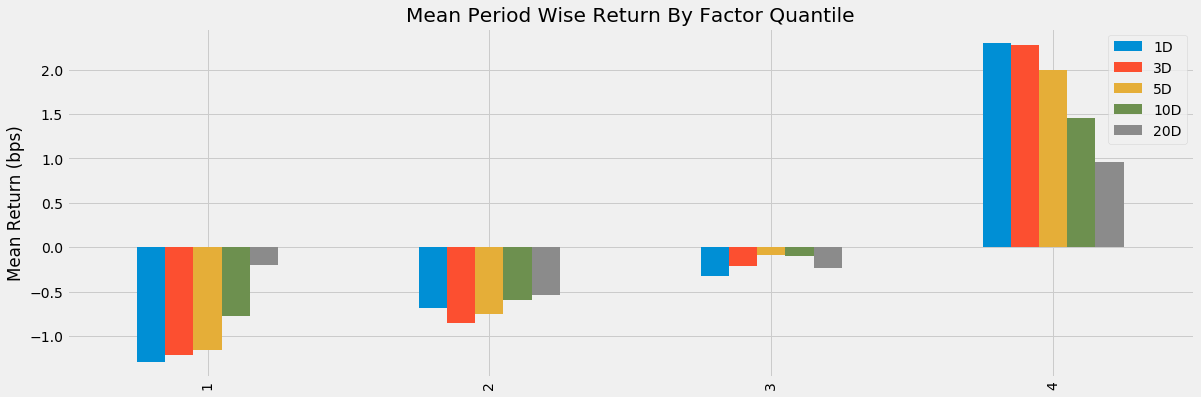

In [168]:
plot_quantile_returns_bar(mean_return_by_q_norm);

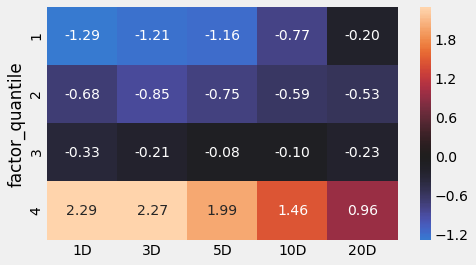

In [169]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.heatmap(mean_return_by_q_norm.mul(10000), center=0, ax=ax, annot=True, fmt='.2f');

#### Daily Return by Factor Quantile

In [170]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(factor_data, by_date=True)

In [171]:
mean_return_by_q_daily.head()

1D        3D        5D       10D       20D
factor_quantile date                                                        
1               2002-01-02 -0.006780 -0.003007 -0.003943 -0.008773 -0.016383
                2002-01-03  0.000483 -0.004025 -0.003340 -0.007860 -0.020129
                2002-01-04  0.001252 -0.002958 -0.011252 -0.026001 -0.030076
                2002-01-07 -0.000898 -0.009212 -0.018389 -0.040355 -0.044096
                2002-01-08 -0.004351 -0.014400 -0.023445 -0.024324 -0.036924

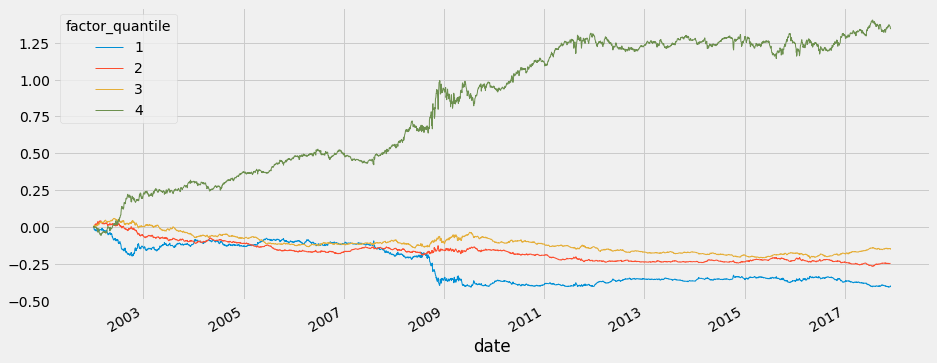

In [173]:
daily_returns = mean_return_by_q_daily['1D'].unstack('factor_quantile')
daily_returns.add(1).cumprod().sub(1).plot(lw=1, figsize=(14, 6));

/home/stefan/projects/algo_trading/04_portfolio/resources/alphalens/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


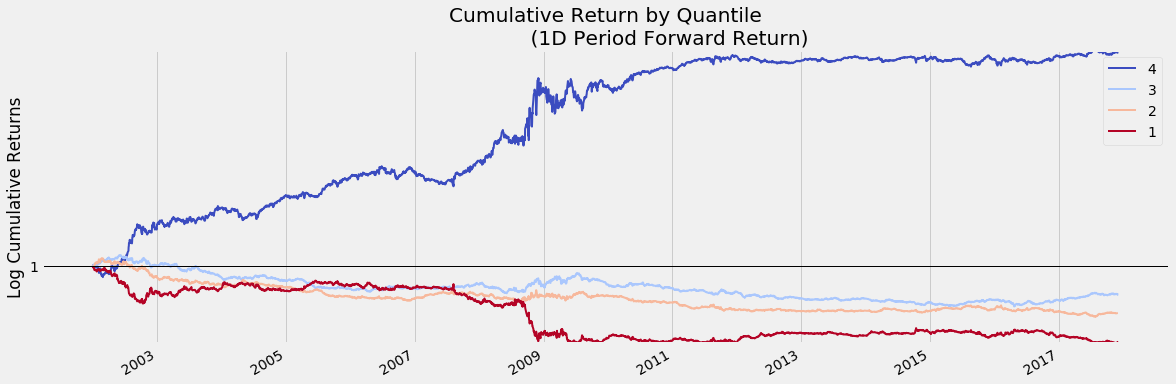

In [174]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['1D'], period='1D');

By looking at the mean return by quantile we can get a real look at how well the factor differentiates forward returns across the signal values. Obviously we want securities with a better signal to exhibit higher returns. For a good factor we'd expect to see negative values in the lower quartiles and positive values in the upper quantiles.

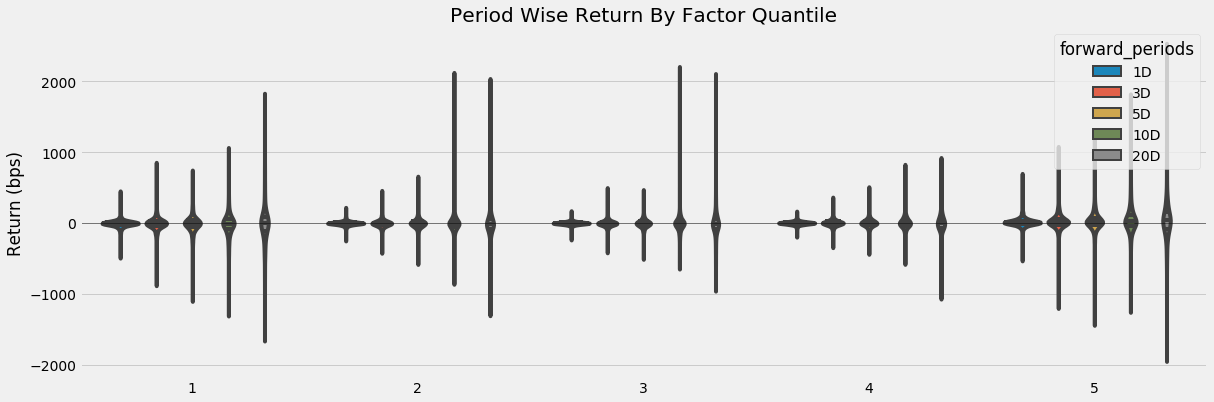

In [76]:
plot_quantile_returns_violin(mean_return_by_q_daily);

This violin plot is similar to the one before it but shows more information about the underlying data. It gives a better idea about the range of values, the median, and the inter-quartile range. What gives the plots their shape is the application of a probability density of the data at different values.

In [79]:
quant_return_spread, std_err_spread = compute_mean_returns_spread(mean_return_by_q_daily,
                                                                  lower_quant=1,
                                                                  upper_quant=5,
                                                                  std_err=std_err)

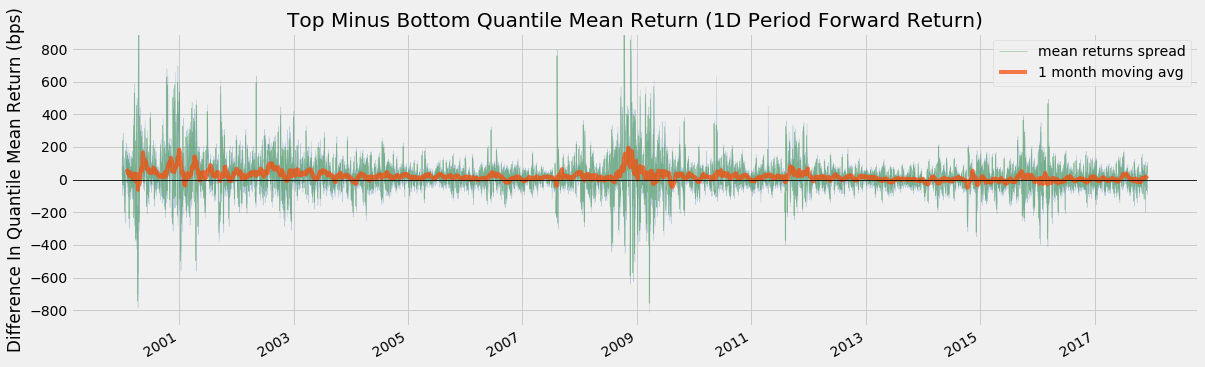

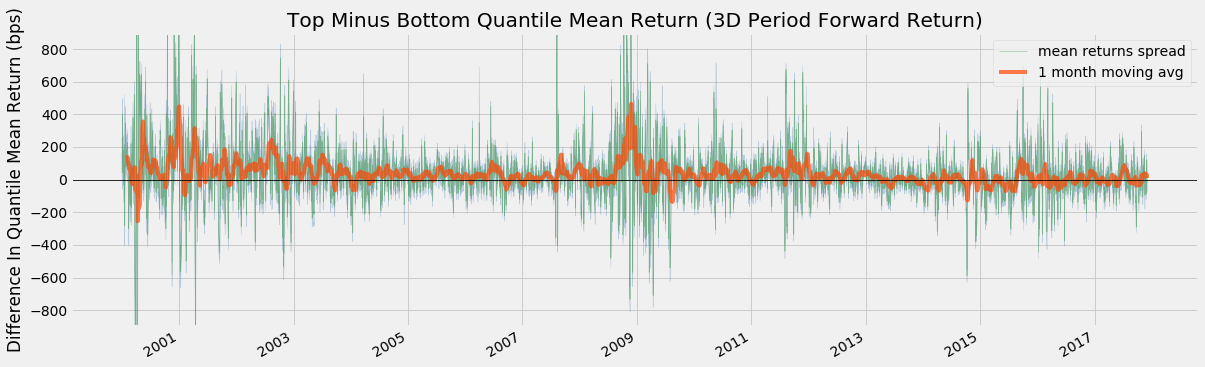

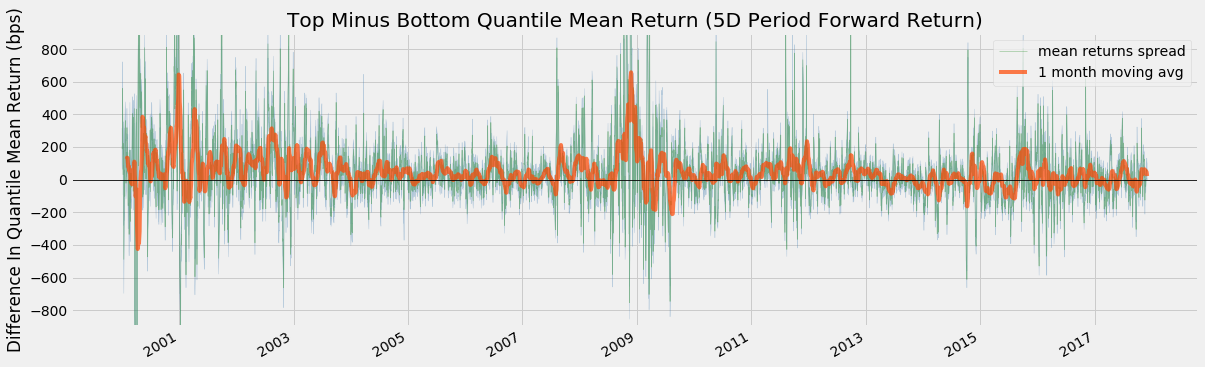

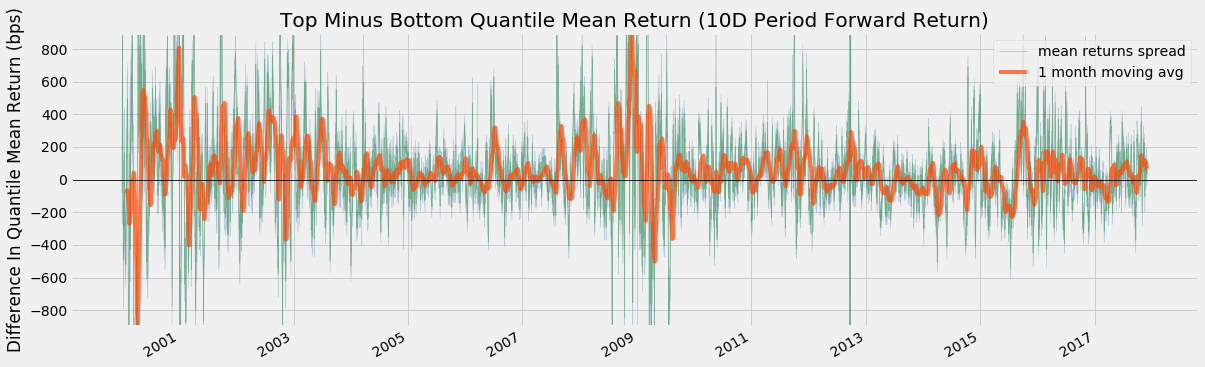

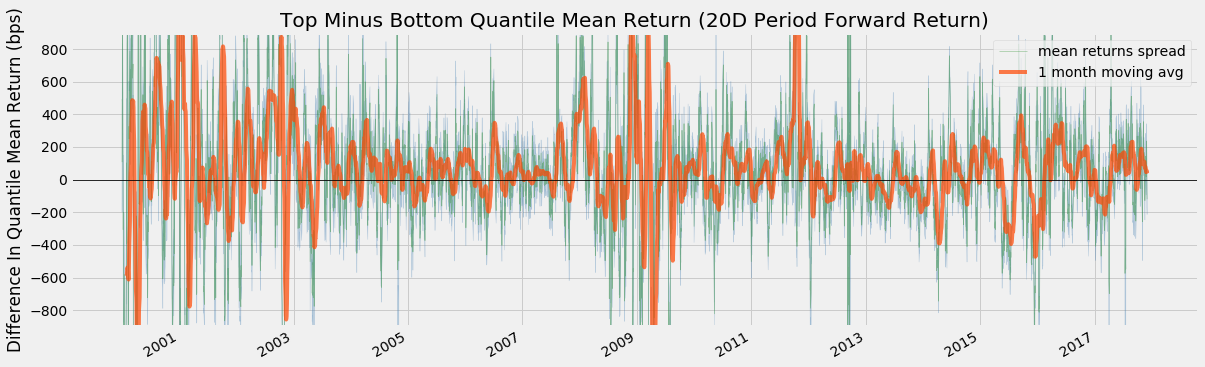

In [80]:
plot_mean_quantile_returns_spread_time_series(quant_return_spread, std_err_spread);

By looking at the cumulative returns by factor quantile we can get an intuition for which quantiles are contributing the most to the factor and at what time. Ideally we would like to see a these curves originate at the same value on the left and spread out like a fan as they move to the right through time, with the higher quantiles on the top.

#### Returns of a Portfolio weighted by Factor Values

`Alphalens` also omputes period wise returns for portfolio weighted by factor values, which implies short positions for negative momentum.

In [85]:
ls_factor_returns = factor_returns(factor_data)

In [86]:
ls_factor_returns.head()

1D        3D        5D       10D       20D
date                                                        
2000-01-03 -0.039540  0.036674  0.038616  0.015785  0.008952
2000-01-04  0.013501  0.039816  0.044615  0.045312  0.034589
2000-01-05  0.030963  0.044384  0.037942  0.051964  0.028555
2000-01-06  0.009356  0.016922  0.025038  0.017992  0.015636
2000-01-07  0.009153  0.008350  0.003059 -0.027301 -0.005724

/home/stefan/projects/algo_trading/04_portfolio/resources/alphalens/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


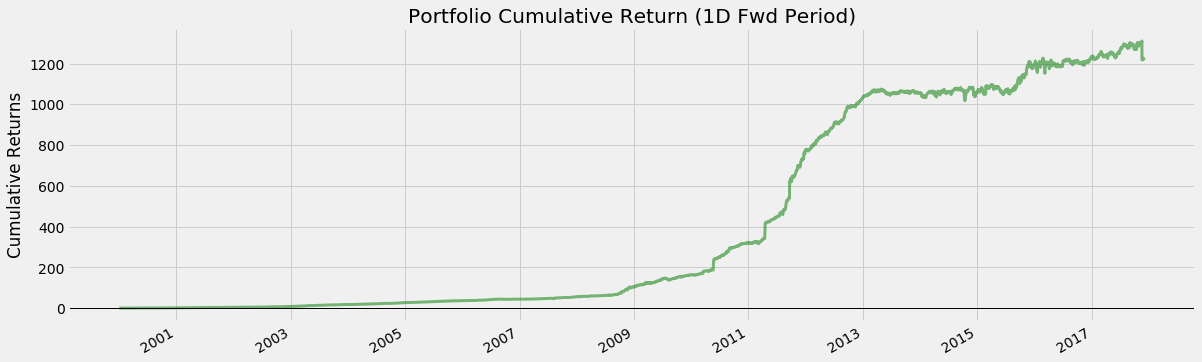

In [87]:
plot_cumulative_returns(ls_factor_returns['1D'], period='1D');

### Summary Tear Sheet

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1               -0.199039  0.017255 -0.006013  0.006174  378935  25.098108
2               -0.038651  0.022682 -0.001382  0.003601  376957  24.967099
3               -0.024793  0.029666  0.001190  0.003565  375955  24.900733
4               -0.016110  0.142332  0.005770  0.005629  377968  25.034060

Returns Analysis


1D     3D     5D    10D  \
Ann. alpha                                     0.046  0.039  0.038  0.028   
beta                                           0.057  0.070  0.065  0.042   
Mean Period Wise Return Top Quantile (bps)     2.294  2.273  1.991  1.456   
Mean Period Wise Return Bottom Quantile (bps) -1.285 -1.211 -1.160 -0.771   
Mean Period Wise Spread (bps)                  3.406  3.367  3.144  2.361   

                                                 20D  
Ann. alpha                                     0.011  
beta                                           0.035  
Mean Period Wise Return Top Quantile (bps)     0.957  
Mean Period Wise Return Bottom Quantile (bps) -0.196  
Mean Period Wise Spread (bps)                  1.216

Information Analysis


1D     3D     5D    10D    20D
IC Mean           0.008  0.013  0.014  0.014  0.011
IC Std.           0.147  0.149  0.145  0.142  0.137
Risk-Adjusted IC  0.055  0.085  0.099  0.099  0.083
t-stat(IC)        3.457  5.384  6.263  6.284  5.274
p-value(IC)       0.001  0.000  0.000  0.000  0.000
IC Skew           0.072  0.152  0.154  0.252  0.059
IC Kurtosis       0.525  0.510  0.398  0.375  0.322

Turnover Analysis


10D     1D    20D     3D     5D
Quantile 1 Mean Turnover   0.799  0.258  0.809  0.436  0.561
Quantile 2 Mean Turnover   0.771  0.495  0.777  0.656  0.715
Quantile 3 Mean Turnover   0.772  0.508  0.774  0.663  0.721
Quantile 4 Mean Turnover   0.804  0.279  0.812  0.454  0.575

1D     3D     5D    10D    20D
Mean Factor Rank Autocorrelation  0.893  0.684  0.472 -0.075 -0.103

<Figure size 432x288 with 0 Axes>

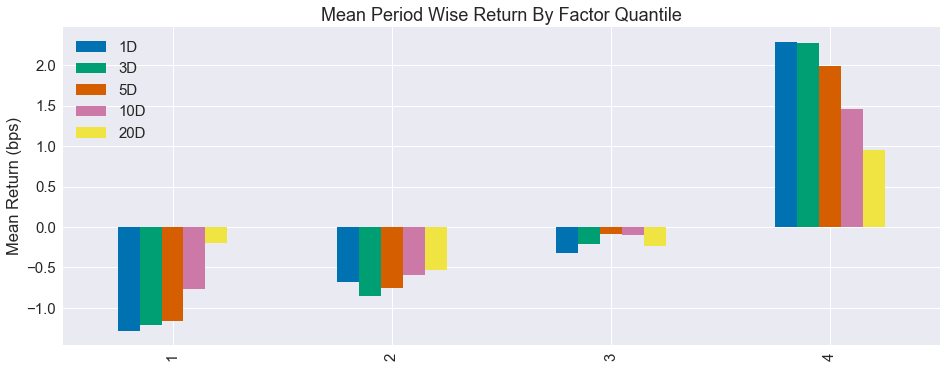

In [175]:
create_summary_tear_sheet(factor_data)

### Returns Tear Sheet

We can view all returns analysis calculations together.

Returns Analysis


1D     3D     5D    10D  \
Ann. alpha                                     0.046  0.039  0.038  0.028   
beta                                           0.057  0.070  0.065  0.042   
Mean Period Wise Return Top Quantile (bps)     2.294  2.273  1.991  1.456   
Mean Period Wise Return Bottom Quantile (bps) -1.285 -1.211 -1.160 -0.771   
Mean Period Wise Spread (bps)                  3.406  3.367  3.144  2.361   

                                                 20D  
Ann. alpha                                     0.011  
beta                                           0.035  
Mean Period Wise Return Top Quantile (bps)     0.957  
Mean Period Wise Return Bottom Quantile (bps) -0.196  
Mean Period Wise Spread (bps)                  1.216

/home/stefan/projects/algo_trading/04_portfolio/resources/alphalens/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)
/home/stefan/projects/algo_trading/04_portfolio/resources/alphalens/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)
/home/stefan/projects/algo_trading/04_portfolio/resources/alphalens/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 432x288 with 0 Axes>

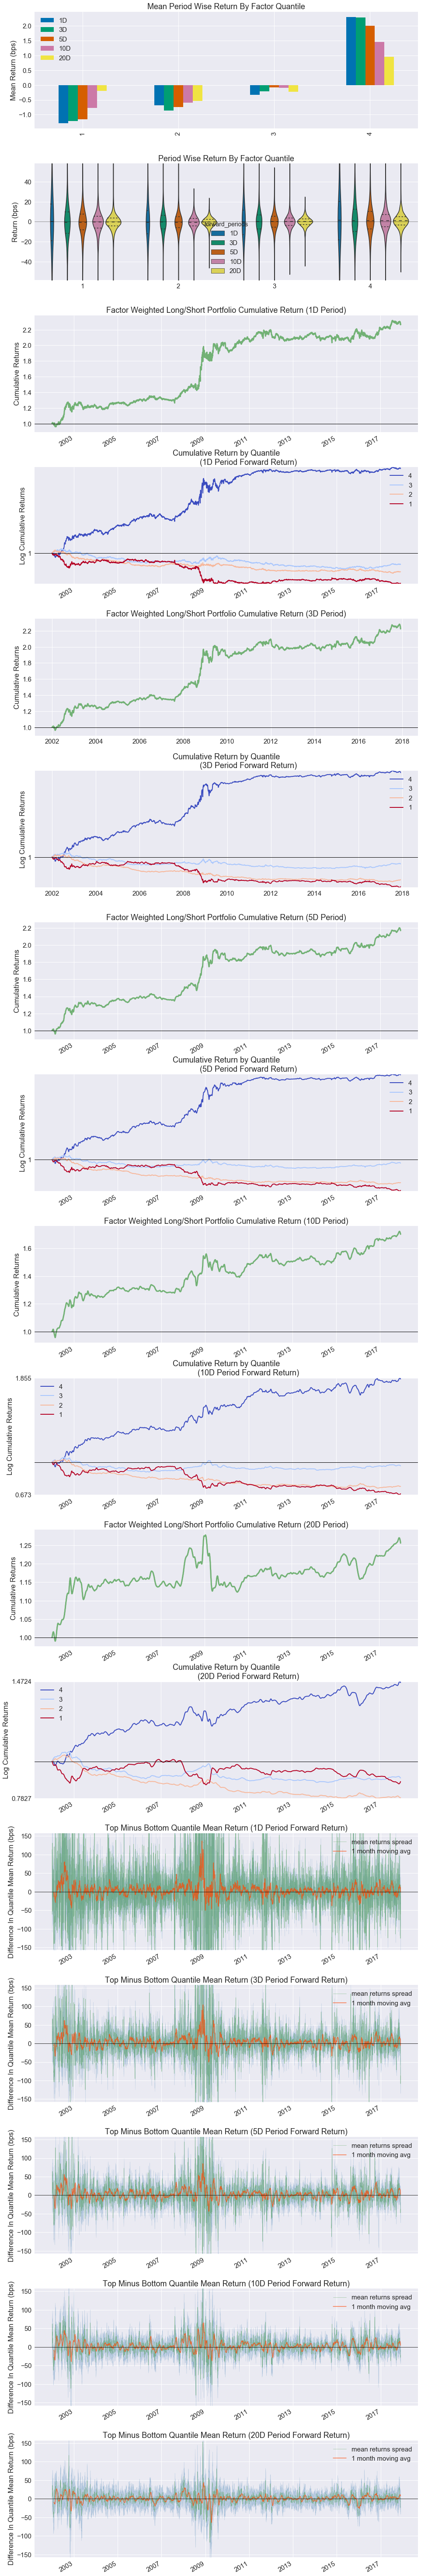

In [176]:
create_returns_tear_sheet(factor_data)

## Get Benchmark

In [ ]:
def get_sp500(start=2010, end=2017):
    with pd.HDFStore(hdf_path) as store:
        sp500 = store['sp500/prices'].close.loc[str(start):str(end)]
        return sp500.to_frame('sp500')


def get_sp500_ret(start=2010, end=2017, fw=1):
    return get_sp500(start, end).pct_change(periods=fw)


def get_sp500_fw(start=2010, end=2017, periods=(1, 5, 10)):
    sp500 = get_sp500(start, end).resample('D').ffill()
    df = pd.concat([(sp500
                     .pct_change(periods=fw)
                     .shift(-fw)
                     .squeeze()
                     .to_frame(f'{fw}D')) for fw in periods], axis=1)
    return df.dropna()


def get_benchmark(factor_data, start=2013, periods=holding_periods):
    factor_dates = factor_data.index.get_level_values('date').unique()
    last = (factor_dates.max() + BDay(max(holding_periods))).year + 1
    return get_sp500_fw(start=start, end=last, periods=periods).reindex(factor_dates)

## Information Analysis

Information Analysis is a way for us to evaluate the predicitive value of a factor without the confounding effects of transaction costs. The main way we look at this is through the Information Coefficient (IC).

From Wikipedia...

>The information coefficient (IC) is a measure of the merit of a predicted value. In finance, the information coefficient is used as a performance metric for the predictive skill of a financial analyst. The information coefficient is similar to correlation in that it can be seen to measure the linear relationship between two random variables, e.g. predicted stock returns and the actualized returns. The information coefficient ranges from 0 to 1, with 0 denoting no linear relationship between predictions and actual values (poor forecasting skills) and 1 denoting a perfect linear relationship (good forecasting skills).

In [177]:
ic = factor_information_coefficient(factor_data)

In [178]:
ic.head()

1D        3D        5D       10D       20D
date                                                        
2002-01-02  0.125776  0.004093  0.097193 -0.019229  0.015139
2002-01-03 -0.040847  0.089025  0.015853 -0.025312 -0.001796
2002-01-04 -0.036356  0.090249  0.213996  0.204388  0.102630
2002-01-07  0.115793  0.198555  0.236013  0.311960  0.189715
2002-01-08  0.044580  0.176346  0.207772  0.185192  0.173259

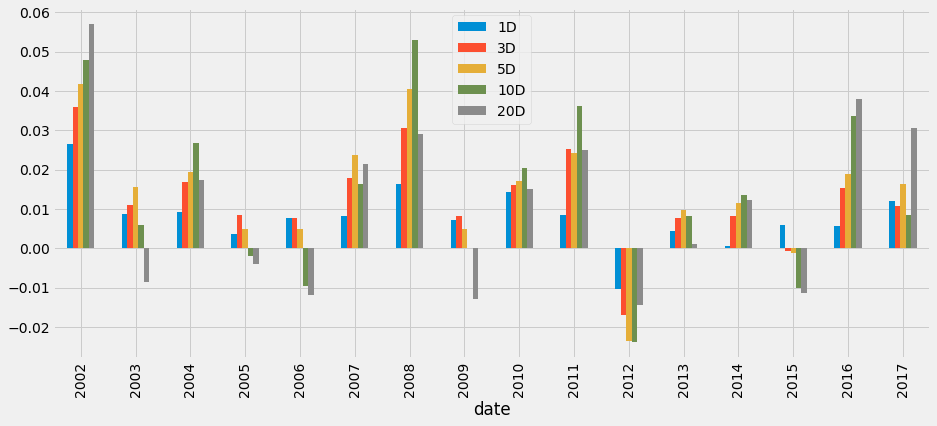

In [193]:
ic = factor_information_coefficient(factor_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14, 6))

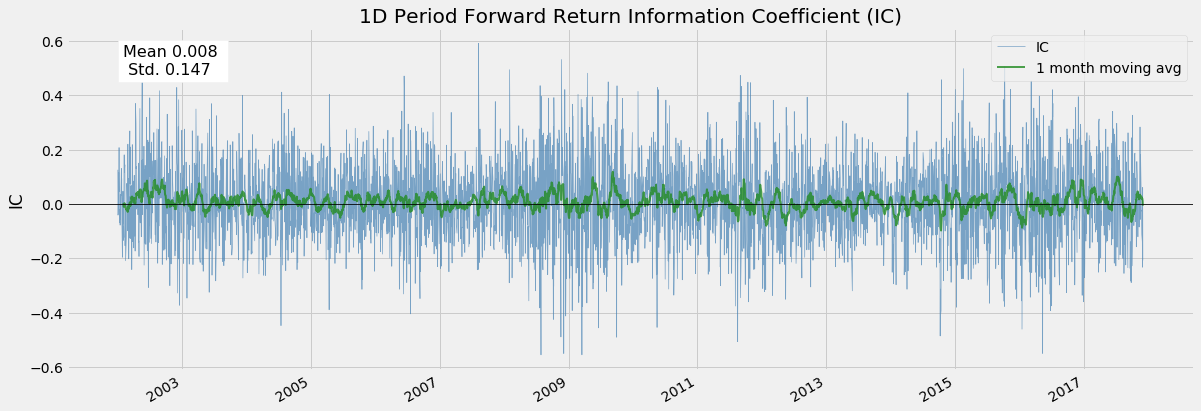

In [189]:
plot_ic_ts(ic[['1D']]);

By looking at the IC each day we can understand how theoretically predicitive our factor is overtime. We like our mean IC to be high and the standard deviation, or volatility of it, to be low. We want to find consistently predictive factors.

In [ ]:
plot_ic_hist(ic);

Looking at a histogram of the daily IC values can indicate how the factor behaves most of the time, where the likely IC values will fall, it also allows us to see if the factor has fat tails.

In [ ]:
plot_ic_qq(ic);

These Q-Q plots show the difference in shape between the distribution of IC values and a normal distribution. This is especially helpful in seeing how the most extreme values in the distribution affect the predicitive power.

In [181]:
mean_monthly_ic = mean_information_coefficient(factor_data, by_time='M')

In [182]:
mean_monthly_ic.head()

1D        3D        5D       10D       20D
date                                                        
2002-01-31  0.009072  0.022228  0.036726 -0.005662 -0.015602
2002-02-28 -0.011452 -0.025862 -0.038482 -0.044662  0.089001
2002-03-31  0.013462  0.023175  0.034189  0.098095  0.178717
2002-04-30  0.038518  0.051359  0.052681  0.037259 -0.034501
2002-05-31  0.051399  0.084737  0.145218  0.185977  0.090663

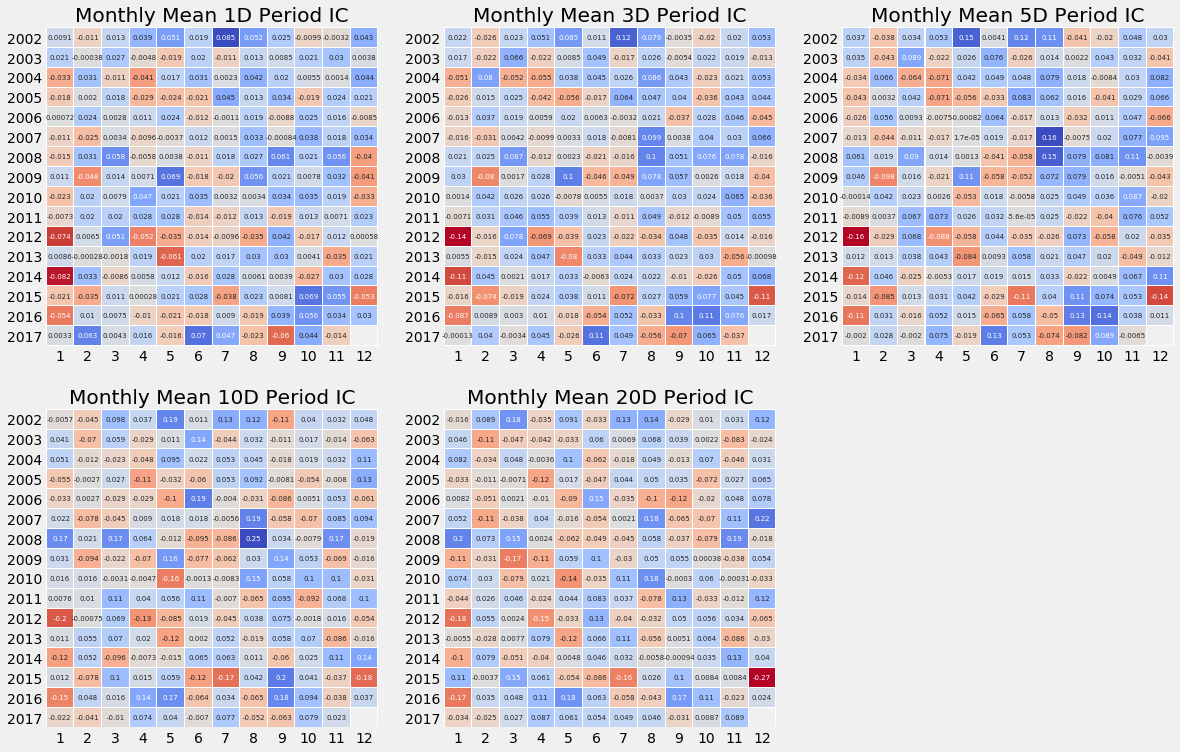

In [186]:
plot_monthly_ic_heatmap(mean_monthly_ic);

### Information Tear Sheet

We can view all information analysis calculations together.

In [ ]:
create_information_tear_sheet(factor_data)

## Turnover Analysis

Turnover Analysis gives us an idea about the nature of a factor's makeup and how it changes.

In [ ]:
quantile_factor = factor_data['factor_quantile']
turnover_period = '1D'

In [ ]:
quantile_turnover = pd.concat([quantile_turnover(quantile_factor, q, turnover_period)
                               for q in quantile_factor.unique()], axis=1)

In [ ]:
quantile_turnover.head()

In [ ]:
plot_top_bottom_quantile_turnover(quantile_turnover, turnover_period);

Factor turnover is important as it indicates the incorporation of new information and the make up of the extremes of a signal. By looking at the new additions to the sets of top and bottom quantiles we can see how much of this factor is getting remade everyday.

In [ ]:
factor_autocorrelation = factor_rank_autocorrelation(factor_data, turnover_period)

In [ ]:
factor_autocorrelation.head()

In [ ]:
plot_factor_rank_auto_correlation(factor_autocorrelation);

The autocorrelation of the factor indicates to us the persistence of the signal itself.

### Turnover Tear Sheet

We can view all turnover calculations together.

In [ ]:
create_turnover_tear_sheet(factor_data)

## Event Style Returns Analysis

Looking at the average cumulative return in a window before and after a factor can indicate to us how long the predicative power of a factor lasts. This tear sheet takes a while to run.

**NOTE:** This tear sheet takes in an extra argument `pricing`.

In [ ]:
# alphalens.tears.create_event_returns_tear_sheet(factor_data, pricing, by_group=True)

## Evaluation by Industry Sector

In [28]:
def get_sectors():
    with pd.HDFStore(hdf_path) as store:
        sp500_meta = store.get('sp500/stocks')
        sectors = sp500_meta[['gics_sector']]
        ids, names = pd.factorize(sectors.gics_sector)
        sectors['id'] = ids
        sector_names = {i: n for i, n in enumerate(names)}
        return sectors, sector_names        

In [29]:
sectors, sector_names = get_sectors()

While looking at quantiles is important we must also look at the factor returns as a whole. The cumulative factor long/short returns plot lets us view the combined effects overtime of our entire factor.

In [ ]:
benchmark = get_benchmark(factor_data_best)

In [ ]:
alpha_beta = factor_alpha_beta(factor_data, returns=benchmark.fillna(0))

In [ ]:
alpha_beta

In [ ]:
alpha_beta.T.plot.bar(title='Alpha-Beta', figsize=(12,6));

Many of the plots in Alphalens can be viewed on their own by grouping if grouping information is provided. The returns and information tear sheets can be viewed groupwise by passing in the `by_group=True` argument.

In [ ]:
ic_by_sector = mean_information_coefficient(factor_data, by_group=True)

In [ ]:
ic_by_sector.head()

In [ ]:
plot_ic_by_group(ic_by_sector);

In [ ]:
mean_return_quantile_sector, mean_return_quantile_sector_err = mean_return_by_quantile(factor_data, by_group=True)

In [ ]:
mean_return_quantile_sector.head()

In [ ]:
plot_quantile_returns_bar(mean_return_quantile_sector, by_group=True);

# The Whole Thing

If you want to see all of the results create a full tear sheet. By passing in the factor data you can analyze all of the above statistics and plots at once.

In [ ]:
alphalens.tears.create_full_tear_sheet(factor_data)

In [ ]:
factor_quantiles = factor.apply(pd.qcut, q=20, labels=False, axis=1)

In [ ]:
data = pd.concat([factor.stack().to_frame('factor'), 
                  factor_quantiles.stack().to_frame('quant')], axis=1)
data.head()

In [ ]:
res = {}
for col in corrs.columns:
    res[col] = corrs[col].abs().nlargest(50).mean()
pd.Series(res).nlargest(5)

In [ ]:
stock_returns = stock_prices.pct_change()

In [ ]:
periods = [1, 3, 5, 10, 30]
forward_returns = pd.DataFrame()
for period in periods:
    p = f'{period}D'
    forward_returns[p] = stock_returns.shift(-period).stack()
forward_returns.head()

### Returns by Quantile

In [ ]:
returns_by_quantile = pd.concat([data, forward_returns], axis=1).dropna(subset=['factor', 'quant'])
returns_by_quantile.quant = returns_by_quantile.quant.astype(int)
returns_by_quantile.info()

In [ ]:
returns_by_quantile.drop('factor', axis=1).groupby('quant').mean().plot.bar(figsize=(15,9));

### Information Coefficient

In [ ]:
ic = pd.DataFrame()
for period in periods:
    p = f'{period}D'
    correlation = returns_by_quantile.groupby('quant')['factor', p].apply(lambda x: x.factor.corr(x[p]))
    ic = pd.concat([ic, correlation.to_frame(p)], axis=1)
ic.index = ic.index.astype(int)

In [ ]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(ic.sort_index(ascending=False), annot=True, fmt='.2%', cmap=cmap, center=0, cbar=False)
plt.gcf().set_size_inches(10, 8)
plt.tight_layout();